In [412]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [ ]:
df = pd.read_csv('Full Database.csv')
df

,Url,Sold,Auction Date,Title,Distillery,Region,Strength,Distillery Status,Cask Type,Currency,...,Cask Filling,Previous Spirit,Regauged Date,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Auction House
0,https://whiskyauctioneer.com/lot/1224-01/cask-...,True,06/01/2025,Port Charlotte 2004 Fresh Bourbon Barrel,Bruichladdich,Islay,50.40,Operational,Barrel,Great Britain Pound (£),...,First Fill,Bourbon,01/10/2024,20.48,212.30,20812.50,87.14,277.87,Scotland,WhiskyAuctioneer
1,https://whiskyauctioneer.com/lot/1124-02a/cask...,False,06/01/2025,Adnams 201Jack Daniel's Barrel,Copper House,England,64.80,Operational,Barrel,Great Britain Pound (£),...,NaN,Bourbon,01/10/2024,13.25,164.86,1125.00,6.07,15.04,England,WhiskyAuctioneer
2,https://whiskyauctioneer.com/lot/1124-01a/cask...,False,06/01/2025,Adnams 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,NaN,NaN,01/10/2024,9.48,247.97,1125.00,4.03,10.08,England,WhiskyAuctioneer
3,https://whiskyauctioneer.com/lot/1124-01/cask-...,False,02/12/2024,Copper House 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,NaN,NaN,01/10/2024,9.39,247.97,281.25,1.01,2.52,England,WhiskyAuctioneer
4,https://whiskyauctioneer.com/lot/0824-05a/cask...,True,02/12/2024,Bruichladdich 2002 Climens Hogshead,Bruichladdich,Islay,53.10,Operational,Hogshead,Great Britain Pound (£),...,NaN,Wine,01/06/2024,NaN,310.20,24187.50,69.31,209.78,Scotland,WhiskyAuctioneer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,https://www.thegrandwhiskyauction.com/lot-6621...,False,06/08/2024,Adnams - Single Malt - French Oak Barrique #482,Adnams,England,64.70,Operational,Barrique,Great Britain Pound (£),...,NaN,NaN,NaN,NaN,250.00,2250.00,9.00,19.87,England,The Grand Whisky Auction
349,https://www.thegrandwhiskyauction.com/lot-6621...,True,06/08/2024,Adnams - Single Malt - French Oak Barrique #468,Adnams,England,68.10,Operational,Barrique,Great Britain Pound (£),...,NaN,NaN,NaN,NaN,242.86,2250.00,9.26,19.44,England,The Grand Whisky Auction
350,https://www.thegrandwhiskyauction.com/lot-6100...,True,14/12/2023,Adnams - Single Malt - Jim Beam - 1st Fill Ame...,Adnams,England,66.41,Operational,Barrel,Great Britain Pound (£),...,First Fill,Bourbon,NaN,NaN,149.57,2137.50,14.29,30.74,England,The Grand Whisky Auction
351,https://www.thegrandwhiskyauction.com/lot-6100...,True,14/12/2023,Adnams - Single Malt - Heaven Hill - 1st Fill ...,Adnams,England,70.20,Operational,Barrel,Great Britain Pound (£),...,First Fill,Bourbon,NaN,NaN,113.86,1800.00,15.81,32.17,England,The Grand Whisky Auction


# Inflation Adjustment

In [414]:
# Transforms date columns to datetime format

df['Filling Date'] = pd.to_datetime(df['Filling Date'], format='%d/%m/%Y')

df['Auction Date'] = pd.to_datetime(df['Auction Date'], format='%d/%m/%Y')
df['Year'] = df['Auction Date'].dt.year
df['Month'] = df['Auction Date'].dt.month

df

,Url,Sold,Auction Date,Title,Distillery,Region,Strength,Distillery Status,Cask Type,Currency,...,Regauged Date,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Auction House,Year,Month
0,https://whiskyauctioneer.com/lot/1224-01/cask-...,True,2025-01-06,Port Charlotte 2004 Fresh Bourbon Barrel,Bruichladdich,Islay,50.40,Operational,Barrel,Great Britain Pound (£),...,01/10/2024,20.48,212.30,20812.50,87.14,277.87,Scotland,WhiskyAuctioneer,2025,1
1,https://whiskyauctioneer.com/lot/1124-02a/cask...,False,2025-01-06,Adnams 201Jack Daniel's Barrel,Copper House,England,64.80,Operational,Barrel,Great Britain Pound (£),...,01/10/2024,13.25,164.86,1125.00,6.07,15.04,England,WhiskyAuctioneer,2025,1
2,https://whiskyauctioneer.com/lot/1124-01a/cask...,False,2025-01-06,Adnams 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,01/10/2024,9.48,247.97,1125.00,4.03,10.08,England,WhiskyAuctioneer,2025,1
3,https://whiskyauctioneer.com/lot/1124-01/cask-...,False,2024-12-02,Copper House 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,01/10/2024,9.39,247.97,281.25,1.01,2.52,England,WhiskyAuctioneer,2024,12
4,https://whiskyauctioneer.com/lot/0824-05a/cask...,True,2024-12-02,Bruichladdich 2002 Climens Hogshead,Bruichladdich,Islay,53.10,Operational,Hogshead,Great Britain Pound (£),...,01/06/2024,NaN,310.20,24187.50,69.31,209.78,Scotland,WhiskyAuctioneer,2024,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,https://www.thegrandwhiskyauction.com/lot-6621...,False,2024-08-06,Adnams - Single Malt - French Oak Barrique #482,Adnams,England,64.70,Operational,Barrique,Great Britain Pound (£),...,NaN,NaN,250.00,2250.00,9.00,19.87,England,The Grand Whisky Auction,2024,8
349,https://www.thegrandwhiskyauction.com/lot-6621...,True,2024-08-06,Adnams - Single Malt - French Oak Barrique #468,Adnams,England,68.10,Operational,Barrique,Great Britain Pound (£),...,NaN,NaN,242.86,2250.00,9.26,19.44,England,The Grand Whisky Auction,2024,8
350,https://www.thegrandwhiskyauction.com/lot-6100...,True,2023-12-14,Adnams - Single Malt - Jim Beam - 1st Fill Ame...,Adnams,England,66.41,Operational,Barrel,Great Britain Pound (£),...,NaN,NaN,149.57,2137.50,14.29,30.74,England,The Grand Whisky Auction,2023,12
351,https://www.thegrandwhiskyauction.com/lot-6100...,True,2023-12-14,Adnams - Single Malt - Heaven Hill - 1st Fill ...,Adnams,England,70.20,Operational,Barrel,Great Britain Pound (£),...,NaN,NaN,113.86,1800.00,15.81,32.17,England,The Grand Whisky Auction,2023,12


In [ ]:
# https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l59c/mm23

df_inflation_gbp = pd.read_csv('series-110625.csv')
df_inflation_gbp

,Title,CPIH MONTHLY RATE 00: ALL ITEMS 2015=100
0,CDID,L59C
1,Source dataset ID,MM23
2,PreUnit,NaN
3,Unit,%
4,Release date,21-05-2025
...,...,...
510,2024 DEC,0.3
511,2025 JAN,0.0
512,2025 FEB,0.4
513,2025 MAR,0.3


In [416]:
df_inflation_gbp = df_inflation_gbp.iloc[68:]
df_inflation_gbp

,Title,CPIH MONTHLY RATE 00: ALL ITEMS 2015=100
68,1988 FEB,0.3
69,1988 MAR,0.4
70,1988 APR,1.3
71,1988 MAY,0.5
72,1988 JUN,0.3
...,...,...
510,2024 DEC,0.3
511,2025 JAN,0.0
512,2025 FEB,0.4
513,2025 MAR,0.3


In [417]:
df_inflation_gbp.columns = ['Date', 'Inflation Rate']

In [418]:
df_inflation_gbp['Date'] = pd.to_datetime(df_inflation_gbp['Date'])
df_inflation_gbp['Year'] = df_inflation_gbp['Date'].dt.year
df_inflation_gbp['Month'] = df_inflation_gbp['Date'].dt.month
df_inflation_gbp['Inflation Rate'] = round(df_inflation_gbp['Inflation Rate'].astype(float) / 100, 6)
df_inflation_gbp

C:\Users\joaov\AppData\Local\Temp\ipykernel_32120\2859149626.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_inflation_gbp['Date'] = pd.to_datetime(df_inflation_gbp['Date'])
C:\Users\joaov\AppData\Local\Temp\ipykernel_32120\2859149626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inflation_gbp['Date'] = pd.to_datetime(df_inflation_gbp['Date'])
C:\Users\joaov\AppData\Local\Temp\ipykernel_32120\2859149626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,Date,Inflation Rate,Year,Month
68,1988-02-01,0.003,1988,2
69,1988-03-01,0.004,1988,3
70,1988-04-01,0.013,1988,4
71,1988-05-01,0.005,1988,5
72,1988-06-01,0.003,1988,6
...,...,...,...,...
510,2024-12-01,0.003,2024,12
511,2025-01-01,0.000,2025,1
512,2025-02-01,0.004,2025,2
513,2025-03-01,0.003,2025,3


In [419]:
df_inflation_gbp = df_inflation_gbp[df_inflation_gbp['Date'] >= '2010-01-01'].reset_index(drop=True)
df_inflation_gbp

,Date,Inflation Rate,Year,Month
0,2010-01-01,-0.002,2010,1
1,2010-02-01,0.003,2010,2
2,2010-03-01,0.004,2010,3
3,2010-04-01,0.005,2010,4
4,2010-05-01,0.002,2010,5
...,...,...,...,...
179,2024-12-01,0.003,2024,12
180,2025-01-01,0.000,2025,1
181,2025-02-01,0.004,2025,2
182,2025-03-01,0.003,2025,3


In [420]:
df_inflation_gbp['Accumulated Inflation'] = (1 + df_inflation_gbp['Inflation Rate'])[::-1].cumprod()[::-1] - 1
df_inflation_gbp['Adjust Value'] = df_inflation_gbp['Accumulated Inflation'] + 1
df_inflation_gbp.drop(columns=['Date','Inflation Rate','Accumulated Inflation'], inplace=True)
df_inflation_gbp

,Year,Month,Adjust Value
0,2010,1,1.548552
1,2010,2,1.551656
2,2010,3,1.547014
3,2010,4,1.540851
4,2010,5,1.533185
...,...,...,...
179,2024,12,1.022153
180,2025,1,1.019096
181,2025,2,1.019096
182,2025,3,1.015036


In [421]:
df = df.merge(df_inflation_gbp, on=['Year', 'Month'], how='left')
df

,Url,Sold,Auction Date,Title,Distillery,Region,Strength,Distillery Status,Cask Type,Currency,...,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Auction House,Year,Month,Adjust Value
0,https://whiskyauctioneer.com/lot/1224-01/cask-...,True,2025-01-06,Port Charlotte 2004 Fresh Bourbon Barrel,Bruichladdich,Islay,50.40,Operational,Barrel,Great Britain Pound (£),...,20.48,212.30,20812.50,87.14,277.87,Scotland,WhiskyAuctioneer,2025,1,1.019096
1,https://whiskyauctioneer.com/lot/1124-02a/cask...,False,2025-01-06,Adnams 201Jack Daniel's Barrel,Copper House,England,64.80,Operational,Barrel,Great Britain Pound (£),...,13.25,164.86,1125.00,6.07,15.04,England,WhiskyAuctioneer,2025,1,1.019096
2,https://whiskyauctioneer.com/lot/1124-01a/cask...,False,2025-01-06,Adnams 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,9.48,247.97,1125.00,4.03,10.08,England,WhiskyAuctioneer,2025,1,1.019096
3,https://whiskyauctioneer.com/lot/1124-01/cask-...,False,2024-12-02,Copper House 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,9.39,247.97,281.25,1.01,2.52,England,WhiskyAuctioneer,2024,12,1.022153
4,https://whiskyauctioneer.com/lot/0824-05a/cask...,True,2024-12-02,Bruichladdich 2002 Climens Hogshead,Bruichladdich,Islay,53.10,Operational,Hogshead,Great Britain Pound (£),...,NaN,310.20,24187.50,69.31,209.78,Scotland,WhiskyAuctioneer,2024,12,1.022153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,https://www.thegrandwhiskyauction.com/lot-6621...,False,2024-08-06,Adnams - Single Malt - French Oak Barrique #482,Adnams,England,64.70,Operational,Barrique,Great Britain Pound (£),...,NaN,250.00,2250.00,9.00,19.87,England,The Grand Whisky Auction,2024,8,1.035499
349,https://www.thegrandwhiskyauction.com/lot-6621...,True,2024-08-06,Adnams - Single Malt - French Oak Barrique #468,Adnams,England,68.10,Operational,Barrique,Great Britain Pound (£),...,NaN,242.86,2250.00,9.26,19.44,England,The Grand Whisky Auction,2024,8,1.035499
350,https://www.thegrandwhiskyauction.com/lot-6100...,True,2023-12-14,Adnams - Single Malt - Jim Beam - 1st Fill Ame...,Adnams,England,66.41,Operational,Barrel,Great Britain Pound (£),...,NaN,149.57,2137.50,14.29,30.74,England,The Grand Whisky Auction,2023,12,1.059513
351,https://www.thegrandwhiskyauction.com/lot-6100...,True,2023-12-14,Adnams - Single Malt - Heaven Hill - 1st Fill ...,Adnams,England,70.20,Operational,Barrel,Great Britain Pound (£),...,NaN,113.86,1800.00,15.81,32.17,England,The Grand Whisky Auction,2023,12,1.059513


In [422]:
df['Adjust Buyer Price'] = round(df['Buyer Price'] * df['Adjust Value'], 2)
df

,Url,Sold,Auction Date,Title,Distillery,Region,Strength,Distillery Status,Cask Type,Currency,...,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Auction House,Year,Month,Adjust Value,Adjust Buyer Price
0,https://whiskyauctioneer.com/lot/1224-01/cask-...,True,2025-01-06,Port Charlotte 2004 Fresh Bourbon Barrel,Bruichladdich,Islay,50.40,Operational,Barrel,Great Britain Pound (£),...,212.30,20812.50,87.14,277.87,Scotland,WhiskyAuctioneer,2025,1,1.019096,21209.94
1,https://whiskyauctioneer.com/lot/1124-02a/cask...,False,2025-01-06,Adnams 201Jack Daniel's Barrel,Copper House,England,64.80,Operational,Barrel,Great Britain Pound (£),...,164.86,1125.00,6.07,15.04,England,WhiskyAuctioneer,2025,1,1.019096,1146.48
2,https://whiskyauctioneer.com/lot/1124-01a/cask...,False,2025-01-06,Adnams 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,247.97,1125.00,4.03,10.08,England,WhiskyAuctioneer,2025,1,1.019096,1146.48
3,https://whiskyauctioneer.com/lot/1124-01/cask-...,False,2024-12-02,Copper House 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,247.97,281.25,1.01,2.52,England,WhiskyAuctioneer,2024,12,1.022153,287.48
4,https://whiskyauctioneer.com/lot/0824-05a/cask...,True,2024-12-02,Bruichladdich 2002 Climens Hogshead,Bruichladdich,Islay,53.10,Operational,Hogshead,Great Britain Pound (£),...,310.20,24187.50,69.31,209.78,Scotland,WhiskyAuctioneer,2024,12,1.022153,24723.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,https://www.thegrandwhiskyauction.com/lot-6621...,False,2024-08-06,Adnams - Single Malt - French Oak Barrique #482,Adnams,England,64.70,Operational,Barrique,Great Britain Pound (£),...,250.00,2250.00,9.00,19.87,England,The Grand Whisky Auction,2024,8,1.035499,2329.87
349,https://www.thegrandwhiskyauction.com/lot-6621...,True,2024-08-06,Adnams - Single Malt - French Oak Barrique #468,Adnams,England,68.10,Operational,Barrique,Great Britain Pound (£),...,242.86,2250.00,9.26,19.44,England,The Grand Whisky Auction,2024,8,1.035499,2329.87
350,https://www.thegrandwhiskyauction.com/lot-6100...,True,2023-12-14,Adnams - Single Malt - Jim Beam - 1st Fill Ame...,Adnams,England,66.41,Operational,Barrel,Great Britain Pound (£),...,149.57,2137.50,14.29,30.74,England,The Grand Whisky Auction,2023,12,1.059513,2264.71
351,https://www.thegrandwhiskyauction.com/lot-6100...,True,2023-12-14,Adnams - Single Malt - Heaven Hill - 1st Fill ...,Adnams,England,70.20,Operational,Barrel,Great Britain Pound (£),...,113.86,1800.00,15.81,32.17,England,The Grand Whisky Auction,2023,12,1.059513,1907.12


In [423]:
df.sort_values('Auction Date', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

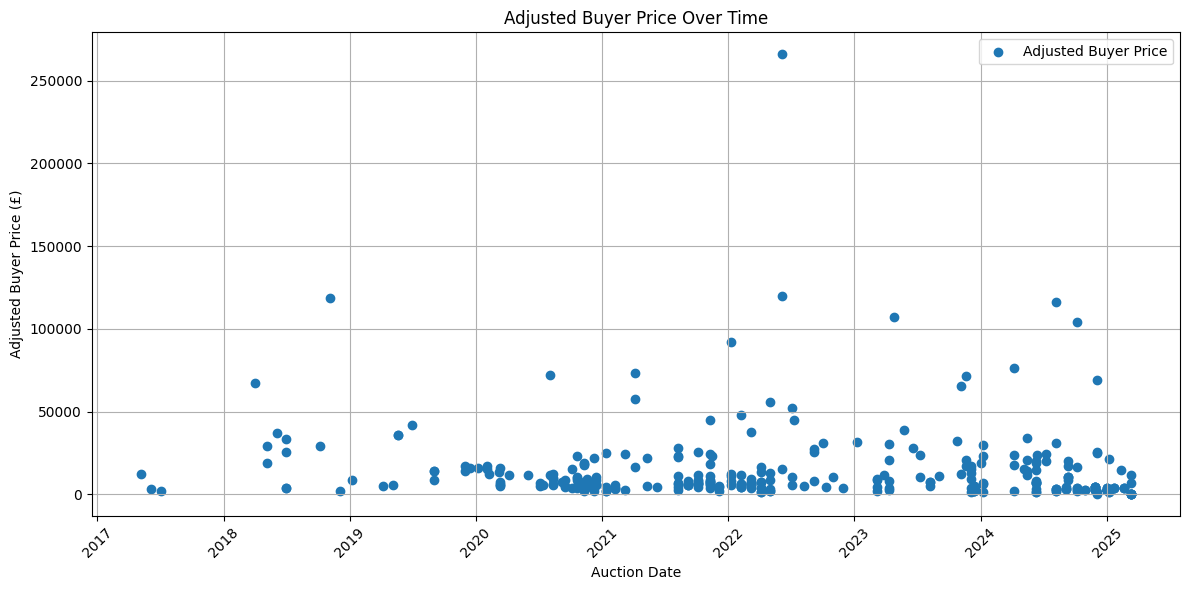

In [424]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Auction Date'], df['Adjust Buyer Price'], label='Adjusted Buyer Price', marker='o')
plt.title('Adjusted Buyer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Adjusted Buyer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Data preparation

In [425]:
# Drops unused columns
df.drop(columns=['Url','Sold','Title','Currency','Filling Date','Regauged Date','Auction House','Buyer Price','Adjust Value','Year','Month','Price Per Bottle At Cask Strength','Price Per Litre Of Alcohol'], inplace=True)
df

,Auction Date,Distillery,Region,Strength,Distillery Status,Cask Type,Bulk Litres,Rla,Cask Filling,Previous Spirit,Age,Bottles At Cask Strength,Country,Adjust Buyer Price
0,2025-03-10,Lochranza,Islands,57.30,Operational,Hogshead,202.70,116.15,First Fill,Sherry,NaN,289.57,Scotland,6965.68
1,2025-03-10,Copper House,England,68.06,Operational,NaN,135.22,92.03,Virgin Oak,Virgin Oak,8.57,193.17,England,399.67
2,2025-03-10,Copper House,England,65.32,Operational,NaN,168.86,110.30,Virgin Oak,Virgin Oak,8.57,241.23,England,399.67
3,2025-03-10,Dublin Liberties Distillery,Ireland,62.20,Operational,Barrel,154.85,96.32,NaN,Bourbon,NaN,221.21,Ireland,399.67
4,2025-03-10,Dublin Liberties Distillery,Ireland,59.01,Operational,Barrel,177.77,104.90,NaN,Bourbon,NaN,253.96,Ireland,399.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,2018-05-07,Ben Nevis,Highlands,57.20,Operational,NaN,398.65,230.76,NaN,Wine,21.44,569.50,Scotland,29410.88
349,2018-04-02,Ben Nevis,Highlands,57.20,Operational,Butt,398.65,230.76,NaN,Sherry,21.34,569.50,Scotland,67118.34
350,2017-07-03,Ardmore,Highlands,NaN,Operational,NaN,NaN,NaN,NaN,Bourbon,7.50,NaN,Scotland,2250.26
351,2017-06-05,Linkwood,Speyside,NaN,Operational,Hogshead,NaN,NaN,Second Fill,NaN,7.43,NaN,Scotland,3300.38


In [426]:
df.isnull().sum()

Auction Date                  0
Distillery                    3
Region                        1
Strength                      5
Distillery Status             1
Cask Type                    42
Bulk Litres                   7
Rla                           9
Cask Filling                174
Previous Spirit             150
Age                          94
Bottles At Cask Strength      7
Country                       2
Adjust Buyer Price            0
dtype: int64

In [427]:
# Drop columns with too much NaN values
df.drop(columns=['Cask Type','Cask Filling','Previous Spirit'], inplace=True)
df

,Auction Date,Distillery,Region,Strength,Distillery Status,Bulk Litres,Rla,Age,Bottles At Cask Strength,Country,Adjust Buyer Price
0,2025-03-10,Lochranza,Islands,57.30,Operational,202.70,116.15,NaN,289.57,Scotland,6965.68
1,2025-03-10,Copper House,England,68.06,Operational,135.22,92.03,8.57,193.17,England,399.67
2,2025-03-10,Copper House,England,65.32,Operational,168.86,110.30,8.57,241.23,England,399.67
3,2025-03-10,Dublin Liberties Distillery,Ireland,62.20,Operational,154.85,96.32,NaN,221.21,Ireland,399.67
4,2025-03-10,Dublin Liberties Distillery,Ireland,59.01,Operational,177.77,104.90,NaN,253.96,Ireland,399.67
...,...,...,...,...,...,...,...,...,...,...,...
348,2018-05-07,Ben Nevis,Highlands,57.20,Operational,398.65,230.76,21.44,569.50,Scotland,29410.88
349,2018-04-02,Ben Nevis,Highlands,57.20,Operational,398.65,230.76,21.34,569.50,Scotland,67118.34
350,2017-07-03,Ardmore,Highlands,NaN,Operational,NaN,NaN,7.50,NaN,Scotland,2250.26
351,2017-06-05,Linkwood,Speyside,NaN,Operational,NaN,NaN,7.43,NaN,Scotland,3300.38


In [428]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

Auction Date                0
Distillery                  0
Region                      0
Strength                    0
Distillery Status           0
Bulk Litres                 0
Rla                         0
Age                         0
Bottles At Cask Strength    0
Country                     0
Adjust Buyer Price          0
dtype: int64

## Outliers filtering

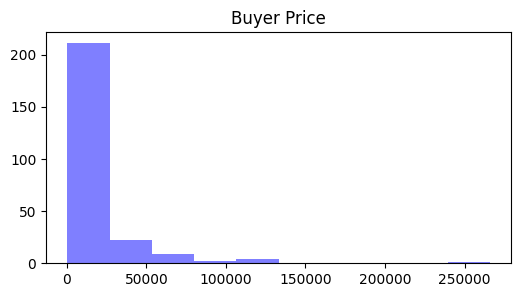

In [429]:
plt.figure(figsize=(6, 3))
plt.hist(df['Adjust Buyer Price'], color='blue', alpha=0.5)
plt.title('Buyer Price')
plt.show()

In [430]:
Q1 = df['Adjust Buyer Price'].quantile(0.25)
Q3 = df['Adjust Buyer Price'].quantile(0.75)
IQR = Q3 - Q1

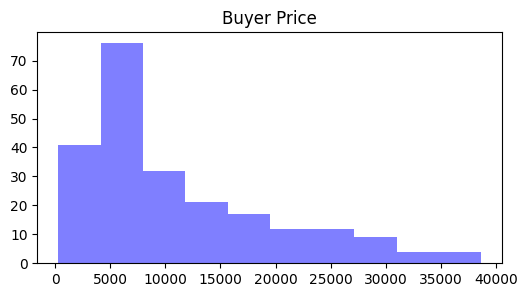

In [431]:

filtro = (df['Adjust Buyer Price'] >= (Q1 - 1.5 * IQR)) & (df['Adjust Buyer Price'] <= (Q3 + 1.5 * IQR))
df = df[filtro].reset_index(drop=True)
plt.figure(figsize=(6, 3))
plt.hist(df['Adjust Buyer Price'], color='blue', alpha=0.5)
plt.title('Buyer Price')
plt.show()

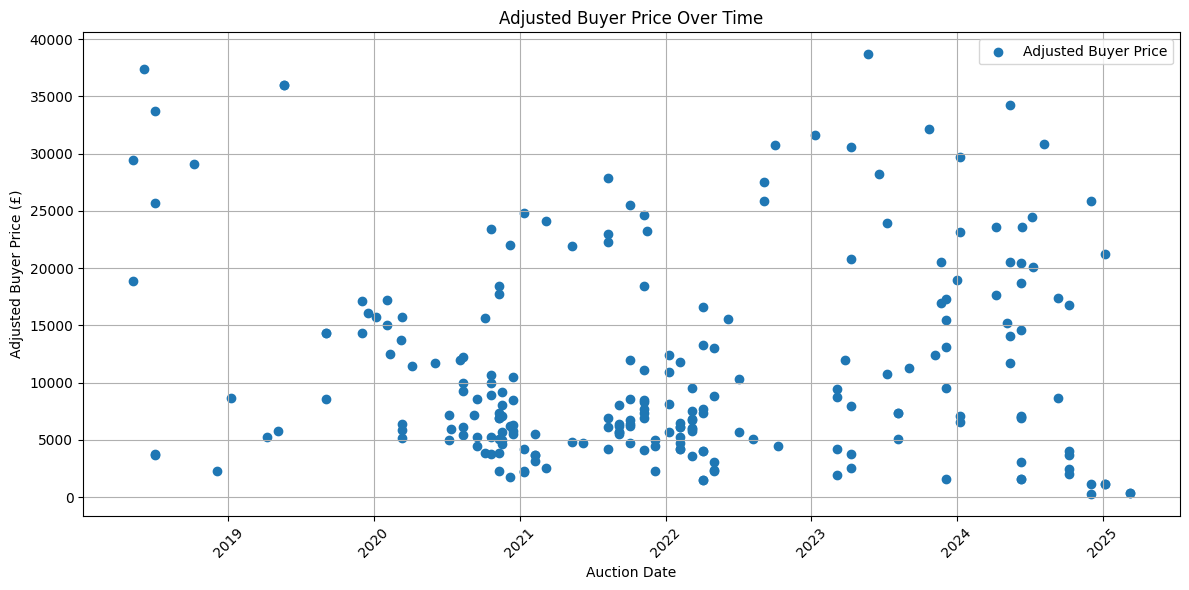

In [432]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Auction Date'], df['Adjust Buyer Price'], label='Adjusted Buyer Price', marker='o')
plt.title('Adjusted Buyer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Adjusted Buyer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [433]:
df.drop(columns=['Auction Date'], inplace=True)

## Log transformation

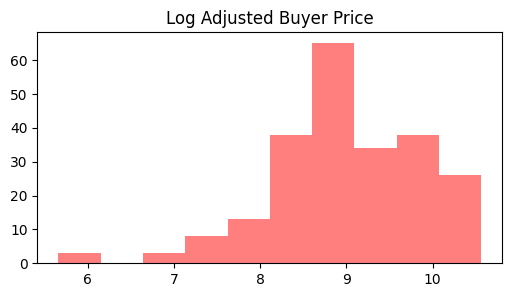

In [434]:
plt.figure(figsize=(6, 3))
plt.hist(np.log(df['Adjust Buyer Price']), color='red', alpha=0.5)
plt.title('Log Adjusted Buyer Price')
plt.show()

## Box-Cox transformation

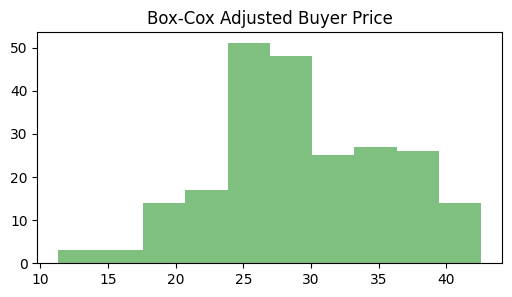

In [435]:
# Supondo que seus dados estejam em y
y_boxcox, fitted_lambda = boxcox(df['Adjust Buyer Price'])

plt.figure(figsize=(6, 3))
plt.hist(y_boxcox, color='green', alpha=0.5)
plt.title('Box-Cox Adjusted Buyer Price')
plt.show()

# Feature selection

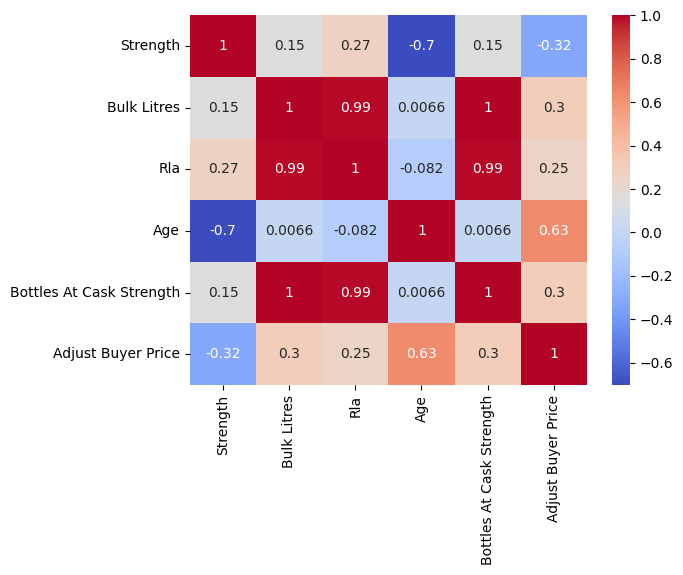

In [436]:
corr = df[['Strength','Bulk Litres','Rla','Age','Bottles At Cask Strength','Adjust Buyer Price']].corr(method='pearson')

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [437]:
# Drop column with high correlation to 'Rla'
df_correlation_selection = df.drop(columns=['Bulk Litres','Bottles At Cask Strength'])

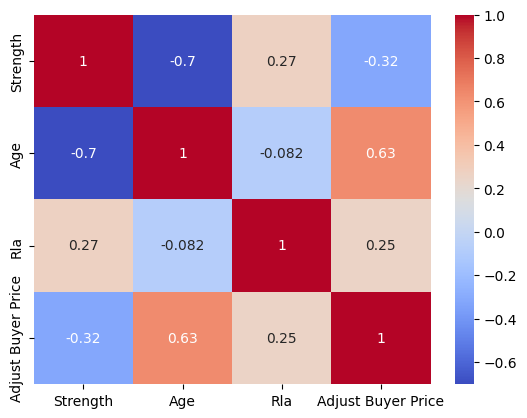

In [438]:
corr = df[['Strength','Age','Rla','Adjust Buyer Price']].corr(method='pearson')

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## One hot encoding for categorical variables

In [439]:
df = pd.get_dummies(df, columns=['Distillery','Region','Distillery Status','Country'], drop_first=True, dtype=int)

In [440]:
df_correlation_selection = pd.get_dummies(df_correlation_selection, columns=['Distillery','Region','Distillery Status','Country'], drop_first=True, dtype=int)

# Split train and test data

In [441]:
from sklearn.model_selection import train_test_split

x = df.drop(columns=['Adjust Buyer Price'])
y = df['Adjust Buyer Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Log transformation
y_train_log = np.log(y_train)

# Box-Cox transformation
y_train_boxcox, fitted_lambda = boxcox(y_train)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

from sklearn.preprocessing import StandardScaler

scaler_x_train = StandardScaler()
x_train[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']] = scaler_x_train.fit_transform(x_train[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']])

scaler_x_test = StandardScaler()
x_test[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']] = scaler_x_test.fit_transform(x_test[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']])

In [442]:
x_train_corr_sel = x_train.drop(columns=['Bulk Litres', 'Bottles At Cask Strength'])
x_test_corr_sel = x_test.drop(columns=['Bulk Litres', 'Bottles At Cask Strength'])

# ML Models - No transformation

In [443]:
models_metrics = {}

## Linear Regression

In [444]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [445]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Linear Regression - All features - No transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 5363.89


,Actual,Predicted,Error
0,36038.23,36328.470402,-290.24
1,1970.83,1325.521527,645.31
2,4024.52,-365.755224,4390.28
3,6357.45,3941.175724,2416.27
4,30871.97,23452.623651,7419.35
5,11714.85,13371.134111,-1656.28
6,18676.26,25694.183335,-7017.92
7,11940.82,6415.669226,5525.15
8,8529.27,12917.329728,-4388.06
9,12014.80,7492.895234,4521.90


## Random Forest

In [446]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
145 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: -5395.20
Best estimator: RandomForestRegressor(max_features='sqrt', random_state=1)


In [447]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Random Forest - All features - No transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 3915.24


,Actual,Predicted,Error
0,36038.23,24266.409900,11771.82
1,1970.83,2503.667025,-532.84
2,4024.52,12706.927900,-8682.41
3,6357.45,5944.498500,412.95
4,30871.97,20404.682300,10467.29
5,11714.85,15407.822100,-3692.97
6,18676.26,13975.250100,4701.01
7,11940.82,6969.779700,4971.04
8,8529.27,6559.895500,1969.37
9,12014.80,7975.255800,4039.54


## SVM

In [448]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best RMSE: -8492.78
Best estimator: SVR(C=10, kernel='linear')


In [449]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['SVM - All features - No transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 7579.77


,Actual,Predicted,Error
0,36038.23,9345.537225,26692.69
1,1970.83,6062.712586,-4091.88
2,4024.52,8970.067715,-4945.55
3,6357.45,7652.551094,-1295.10
4,30871.97,10886.430837,19985.54
5,11714.85,7865.708122,3849.14
6,18676.26,10321.373439,8354.89
7,11940.82,7656.621810,4284.20
8,8529.27,7429.016625,1100.25
9,12014.80,8194.509086,3820.29


## Gradient Boosting

In [450]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE: -5075.35
Best estimator: GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                          n_estimators=200, random_state=1)


In [451]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Gradient Boost - All features - No transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 3544.05


,Actual,Predicted,Error
0,36038.23,37569.218975,-1530.99
1,1970.83,1323.521627,647.31
2,4024.52,9668.517795,-5644.00
3,6357.45,7725.322629,-1367.87
4,30871.97,17545.232632,13326.74
5,11714.85,12169.858578,-455.01
6,18676.26,16939.891072,1736.37
7,11940.82,7722.580147,4218.24
8,8529.27,9792.393461,-1263.12
9,12014.80,8745.395464,3269.40


# ML Models - Log transformation

## Linear Regression

In [452]:
model = LinearRegression()
model.fit(x_train, y_train_log)

y_pred = model.predict(x_test)

In [453]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Linear Regression - All features - Log transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4695.10


,Actual,Predicted,Error
0,36038.23,32884.004470,3154.23
1,1970.83,2323.529633,-352.70
2,4024.52,1425.459083,2599.06
3,6357.45,4034.246206,2323.20
4,30871.97,28971.002078,1900.97
5,11714.85,11802.469091,-87.62
6,18676.26,26359.860618,-7683.60
7,11940.82,4842.229263,7098.59
8,8529.27,5112.067065,3417.20
9,12014.80,7422.838190,4591.96


## Random Forest

In [454]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
271 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best RMSE: -0.49
Best estimator: RandomForestRegressor(max_features='sqrt', min_samples_split=5, random_state=1)


In [455]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Random Forest - All features - Log transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4680.70


,Actual,Predicted,Error
0,36038.23,13640.070950,22398.16
1,1970.83,2307.146780,-336.32
2,4024.52,8605.979436,-4581.46
3,6357.45,4755.789705,1601.66
4,30871.97,17422.227706,13449.74
5,11714.85,12384.001525,-669.15
6,18676.26,12780.196666,5896.06
7,11940.82,5683.409727,6257.41
8,8529.27,3443.744536,5085.53
9,12014.80,7801.459443,4213.34


## SVM

In [456]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best RMSE: -0.47
Best estimator: SVR(C=10)


In [457]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['SVM - All features - Log transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 3709.43


,Actual,Predicted,Error
0,36038.23,37161.704533,-1123.47
1,1970.83,1681.362548,289.47
2,4024.52,4251.558222,-227.04
3,6357.45,6072.973616,284.48
4,30871.97,17639.175404,13232.79
5,11714.85,15832.986928,-4118.14
6,18676.26,16021.471731,2654.79
7,11940.82,4533.097386,7407.72
8,8529.27,4352.725043,4176.54
9,12014.80,7892.361822,4122.44


## Gradient Boosting

In [458]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best RMSE: -0.45
Best estimator: GradientBoostingRegressor(min_samples_leaf=4, min_samples_split=10,
                          n_estimators=50, random_state=1)


In [459]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Gradient Boost - All features - Log transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4985.74


,Actual,Predicted,Error
0,36038.23,17723.269388,18314.96
1,1970.83,1862.986600,107.84
2,4024.52,9930.264286,-5905.74
3,6357.45,5074.061722,1283.39
4,30871.97,17974.998783,12896.97
5,11714.85,11200.739163,514.11
6,18676.26,23205.759753,-4529.50
7,11940.82,7271.963244,4668.86
8,8529.27,7643.066056,886.20
9,12014.80,8772.705019,3242.09


# ML Models - Box-Cox transformation

## Linear Regression

In [460]:
model = LinearRegression()
model.fit(x_train, y_train_boxcox)

y_pred = model.predict(x_test)

In [461]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Linear Regression - All features - Box-Cox transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4399.88


,Actual,Predicted,Error
0,36038.23,34650.874337,1387.36
1,1970.83,2249.724827,-278.89
2,4024.52,1176.116757,2848.40
3,6357.45,4068.521523,2288.93
4,30871.97,26332.748352,4539.22
5,11714.85,12363.234004,-648.38
6,18676.26,25859.626478,-7183.37
7,11940.82,5165.119075,6775.70
8,8529.27,7137.910294,1391.36
9,12014.80,7445.994093,4568.81


## Random Forest

In [462]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -4.54
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
114 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

In [463]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Random Forest - All features - Box-Cox transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4275.01


,Actual,Predicted,Error
0,36038.23,18435.517011,17602.71
1,1970.83,2358.213497,-387.38
2,4024.52,10890.043507,-6865.52
3,6357.45,5258.897597,1098.55
4,30871.97,18425.692027,12446.28
5,11714.85,13440.991197,-1726.14
6,18676.26,13013.943442,5662.32
7,11940.82,6302.174865,5638.65
8,8529.27,5212.113805,3317.16
9,12014.80,7646.989931,4367.81


## SVM

In [464]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
Best RMSE: -4.21
Best estimator: SVR(C=10, epsilon=0.5)


In [465]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['SVM - All features - Box-Cox transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 3843.29


,Actual,Predicted,Error
0,36038.23,21615.002350,14423.23
1,1970.83,2287.479403,-316.65
2,4024.52,9979.854224,-5955.33
3,6357.45,5100.758516,1256.69
4,30871.97,20553.981266,10317.99
5,11714.85,14642.116981,-2927.27
6,18676.26,20532.751828,-1856.49
7,11940.82,6451.726838,5489.09
8,8529.27,6208.181079,2321.09
9,12014.80,7842.723423,4172.08


## Gradient Boosting

In [466]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: -4.22
Best estimator: GradientBoostingRegressor(min_samples_leaf=4, random_state=1)


In [467]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Gradient Boost - All features - Box-Cox transformation'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4689.01


,Actual,Predicted,Error
0,36038.23,25197.872428,10840.36
1,1970.83,2076.733558,-105.90
2,4024.52,10333.808794,-6309.29
3,6357.45,4720.929646,1636.52
4,30871.97,15585.541149,15286.43
5,11714.85,11950.523837,-235.67
6,18676.26,28896.930136,-10220.67
7,11940.82,6576.167326,5364.65
8,8529.27,8401.850575,127.42
9,12014.80,9405.901009,2608.90


# ML Models - No transformation - Correlation Selection

## Linear Regression

In [468]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train)

y_pred = model.predict(x_test_corr_sel)

In [469]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Linear Regression - All features - No transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 5445.96


,Actual,Predicted,Error
0,36038.23,38169.032275,-2130.80
1,1970.83,1114.791178,856.04
2,4024.52,-1508.760056,5533.28
3,6357.45,4747.628989,1609.82
4,30871.97,22360.600134,8511.37
5,11714.85,14074.580247,-2359.73
6,18676.26,27307.844083,-8631.58
7,11940.82,7791.195878,4149.62
8,8529.27,12750.672850,-4221.40
9,12014.80,7504.686275,4510.11


## Random Forest

In [470]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -5635.99
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
257 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

In [471]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Random Forest - All features - No transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 3944.13


,Actual,Predicted,Error
0,36038.23,25838.00280,10200.23
1,1970.83,2239.15410,-268.32
2,4024.52,12002.27300,-7977.75
3,6357.45,6701.77420,-344.32
4,30871.97,19671.95920,11200.01
5,11714.85,15532.38300,-3817.53
6,18676.26,14024.05500,4652.20
7,11940.82,6697.72960,5243.09
8,8529.27,6260.53720,2268.73
9,12014.80,7566.41500,4448.38


## SVM

In [472]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best RMSE: -8662.93
Best estimator: SVR(C=10, kernel='linear')


In [473]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['SVM - All features - No transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 7727.39


,Actual,Predicted,Error
0,36038.23,9261.908806,26776.32
1,1970.83,6561.668230,-4590.84
2,4024.52,8610.453869,-4585.93
3,6357.45,7331.070018,-973.62
4,30871.97,10837.526617,20034.44
5,11714.85,7751.704150,3963.15
6,18676.26,10432.406480,8243.85
7,11940.82,7321.064206,4619.76
8,8529.27,7293.433752,1235.84
9,12014.80,7974.887004,4039.91


## Gradient Boosting

In [474]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -5275.43
Best estimator: GradientBoostingRegressor(n_estimators=50, random_state=1)


In [475]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Gradient Boost - All features - No transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4163.04


,Actual,Predicted,Error
0,36038.23,32282.397619,3755.83
1,1970.83,2713.688210,-742.86
2,4024.52,9871.436153,-5846.92
3,6357.45,7254.426397,-896.98
4,30871.97,15684.527785,15187.44
5,11714.85,16546.437718,-4831.59
6,18676.26,23158.941437,-4482.68
7,11940.82,7696.337211,4244.48
8,8529.27,9545.950356,-1016.68
9,12014.80,7431.293038,4583.51


# ML Models - Log transformation - Correlation Selection

## Linear Regression

In [476]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_log)

y_pred = model.predict(x_test_corr_sel)

In [477]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Linear Regression - All features - Log transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4739.54


,Actual,Predicted,Error
0,36038.23,41579.877046,-5541.65
1,1970.83,2242.272284,-271.44
2,4024.52,1148.700145,2875.82
3,6357.45,4386.131530,1971.32
4,30871.97,25860.034720,5011.94
5,11714.85,12841.671613,-1126.82
6,18676.26,31839.328886,-13163.07
7,11940.82,5883.327594,6057.49
8,8529.27,5071.503960,3457.77
9,12014.80,7487.852200,4526.95


## Random Forest

In [478]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE: -0.50
Best estimator: RandomForestRegressor(max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=1)


In [479]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Random Forest - All features - Log transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4698.30


,Actual,Predicted,Error
0,36038.23,16147.159579,19891.07
1,1970.83,2504.502117,-533.67
2,4024.52,8984.389322,-4959.87
3,6357.45,5063.835449,1293.61
4,30871.97,16556.123388,14315.85
5,11714.85,13053.973311,-1339.12
6,18676.26,14155.854059,4520.41
7,11940.82,6231.903815,5708.92
8,8529.27,4234.049640,4295.22
9,12014.80,7352.491737,4662.31


## SVM

In [480]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best RMSE: -0.46
Best estimator: SVR(C=1)


In [481]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['SVM - All features - Log transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 3931.59


,Actual,Predicted,Error
0,36038.23,24409.865775,11628.36
1,1970.83,2402.988255,-432.16
2,4024.52,10623.431517,-6598.91
3,6357.45,5100.405772,1257.04
4,30871.97,16652.924679,14219.05
5,11714.85,15139.126281,-3424.28
6,18676.26,18139.997790,536.26
7,11940.82,7095.477454,4845.34
8,8529.27,5509.219202,3020.05
9,12014.80,7922.890065,4091.91


## Gradient Boosting

In [482]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best RMSE: -0.45
Best estimator: GradientBoostingRegressor(max_depth=5, min_samples_split=10, n_estimators=50,
                          random_state=1)


In [483]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Gradient Boost - All features - Log transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 3725.47


,Actual,Predicted,Error
0,36038.23,35205.901726,832.33
1,1970.83,1822.819214,148.01
2,4024.52,9029.958694,-5005.44
3,6357.45,5962.724881,394.73
4,30871.97,13053.967211,17818.00
5,11714.85,17524.718617,-5809.87
6,18676.26,21679.386988,-3003.13
7,11940.82,7248.487196,4692.33
8,8529.27,9793.315093,-1264.05
9,12014.80,8428.383695,3586.42


# ML Models - Box-Cox transformation - Correlation Selection

## Linear Regression

In [484]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_boxcox)

y_pred = model.predict(x_test_corr_sel)

In [485]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Linear Regression - All features - Box-Cox transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4463.31


,Actual,Predicted,Error
0,36038.23,40193.300098,-4155.07
1,1970.83,2153.223273,-182.39
2,4024.52,854.766706,3169.75
3,6357.45,4470.037025,1887.41
4,30871.97,24260.099763,6611.87
5,11714.85,13264.552563,-1549.70
6,18676.26,29466.432239,-10790.17
7,11940.82,6269.436459,5671.38
8,8529.27,7069.587834,1459.68
9,12014.80,7499.526421,4515.27


## Random Forest

In [486]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -4.65
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

In [487]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Random Forest - All features - Box-Cox transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4623.86


,Actual,Predicted,Error
0,36038.23,16327.828034,19710.40
1,1970.83,2290.143292,-319.31
2,4024.52,10463.246105,-6438.73
3,6357.45,5757.885122,599.56
4,30871.97,17824.844122,13047.13
5,11714.85,13282.049088,-1567.20
6,18676.26,12674.467873,6001.79
7,11940.82,6230.382429,5710.44
8,8529.27,3506.452602,5022.82
9,12014.80,7317.089483,4697.71


## SVM

In [488]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
Best RMSE: -4.25
Best estimator: SVR(C=10, epsilon=0.5)


In [489]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['SVM - All features - Box-Cox transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 4024.70


,Actual,Predicted,Error
0,36038.23,25128.953636,10909.28
1,1970.83,2442.789035,-471.96
2,4024.52,11080.139399,-7055.62
3,6357.45,4940.994391,1416.46
4,30871.97,16543.846198,14328.12
5,11714.85,15023.821919,-3308.97
6,18676.26,19281.394494,-605.13
7,11940.82,7348.337191,4592.48
8,8529.27,6636.205076,1893.06
9,12014.80,8083.747566,3931.05


## Gradient Boosting

In [490]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: -4.36
Best estimator: GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=2,
                          min_samples_split=10, random_state=1)


In [491]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Gradient Boost - All features - Box-Cox transformation - Correlation Selection'] = {'RMSE': rmse}

pred_vs_test

RMSE: 3825.55


,Actual,Predicted,Error
0,36038.23,24111.385153,11926.84
1,1970.83,2103.577460,-132.75
2,4024.52,10234.148020,-6209.63
3,6357.45,5959.912661,397.54
4,30871.97,16796.340531,14075.63
5,11714.85,10638.924430,1075.93
6,18676.26,20541.046008,-1864.79
7,11940.82,7386.321779,4554.50
8,8529.27,8902.450198,-373.18
9,12014.80,9376.287250,2638.51


# Metrics

In [492]:
models_metrics = pd.DataFrame(models_metrics).T
models_metrics['RMSE'] = models_metrics['RMSE'].round(2)
models_metrics

,RMSE
Linear Regression - All features - No transformation,5363.89
Random Forest - All features - No transformation,3915.24
SVM - All features - No transformation,7579.77
Gradient Boost - All features - No transformation,3544.05
Linear Regression - All features - Log transformation,4695.10
Random Forest - All features - Log transformation,4680.70
SVM - All features - Log transformation,3709.43
Gradient Boost - All features - Log transformation,4985.74
Linear Regression - All features - Box-Cox transformation,4399.88
Random Forest - All features - Box-Cox transformation,4275.01
